### Analysis of KELT-11b 

This notebook demonstrates the main features of pycheops for the analysis of as single transit of KELT-11 b observed by CHEOPS.

To run this notebook ...
* Install an up-to-date version python3 (version 3.7 or later),  e.g., https://www.anaconda.com/distribution/
* Install the latest version of pycheops using "pip install pycheops" - you may also need the "--upgrade" and/or "--user" options
* Configure your pycheops installation
```
>>> from pycheops.core import setup_config
```

* Install the DACE API (https://dace.unige.ch/pythonAPI/)


#### Setup
Using pylab to import numpy, scipy and matplotlib.

Use ```%pylab notebook``` for interactive plots, but be aware that plots may not appear in the window you expect if you do not stop the plot interaction in one cell and then run plotting commands in another cell.



In [1]:
%pylab inline
import pycheops

Populating the interactive namespace from numpy and matplotlib


### Properties of KELT-11b

The light curve for a planet of radius $R_p$ transiting a star of radius $R_s$ with impact parameter $b$ is calculated using the power-2 limb-darkening law, 
$$I_{\lambda}(\mu) = 1 - c(1 - \mu^{\alpha}),$$
and is described by the following parameters.

- T_0:   time of mid-transit
- P:     orbital period
- D:     depth, $(R_p/R_s)^2 = k^2$
- W:     width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     impact parameter, $a\cos(i)/R_s$
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$
- f_s:   $\sqrt{e}\sin(\omega)$
- h_1:   $I_{\lambda}(0.5) = 1 - c(1-2^{-\alpha})$
- h_2:   $I_{\lambda}(0.5) - I_{\lambda}(0) = c\cdot2^{-\alpha}$


See `help(pycheops.models.TransitModel)` for more information on the transit model.

For a circular orbit, the parameter W is the transit duration in phase units (not true for eccentric orbits).

Initial values for some/all of these parameters can be obtained using the PlanetProperties class. For CHEOPS science team members, this will use the latest information on the planet stored in a table at [DACE](https://dace.unige.ch/cheops/). For non-CST members, or if the planet is not in the DACE table, the information will be obtained from [TEPCat](https://www.astro.keele.ac.uk/jkt/tepcat/). You can use the keyword option "query_dace=False to suppress warnings of you do not have access to DACE.

In [2]:
Kelt11b = pycheops.PlanetProperties('KELT-11b')  #  query_dace=False
print(Kelt11b)

Target  KELT-11b  found in DACE-Planets.
Identifier : KELT-11b
T0 : 2457024.0180 +/- 0.0031 BJD       [DACE-Planets]
P :     4.7365250 +/- 0.0000670 days   [DACE-Planets]
D :  2670.0000 +/- 270.0000 ppm         [DACE-Planets]
W :  0.3043 +/- 0.0053 days            [DACE-Planets]
ecosw : -0.0040 +/- 0.0490             [DACE-Planets]
esinw : +0.0310 +/- 0.0680             [DACE-Planets]
ecc : 0.0313 +/- 0.0677                [Derived]
omega : +1.69912 +/- 1.57949 radian    [Derived]
f_c : -0.0226 +/- 0.2760               [Derived]
f_s : +0.1753 +/- 0.1963               [Derived]



### Load the dataset and select an aperture size for the light curve data
A query to DACE is used to obtain the file key for the observation of KELT-11b during in-orbit commissioning (prog_id=24).

If the data are not already in your pycheops cache directory then pycheops will attempt to downloaded them from DACE (assuming you have setup your access correctly).

There may be multiple versions of the data set in DACE so we use the data_proc_num attribute to select the latest version.

The data reduction pipeline (DRP) report is shown when you download the report. To view the report again at a later time you can use the command `dataset.view_report()`

The output from `dataset.get_lightcurve` is the numpy arrays time, flux and flux_err. We do not need these yet so we send the output to a variable `_`. **N.B.** you must decide whether or not to apply a correction for contamination of the aperture by nearby stars (`decontaminate=True` or `decontaminate=False`). There is some uncertainty in this correction so, in some cases, using `decontaminate=True` can add noise to the light curve.

In [3]:
from dace.cheops import Cheops
myfilter = {'obj_id_catname': {'contains':'KELT-11b','prog_id':24}}
data = Cheops.query_database(filters=myfilter)
i_last_data_proc_num = np.argmax(data['data_proc_num'])
file_key = data['file_key'][i_last_data_proc_num]
dataset = pycheops.Dataset(file_key)
_ = dataset.get_lightcurve(aperture='OPTIMAL',decontaminate=True)

Found archive tgzfile /Users/pflm/pycheops/data/CH_PR300024_TG000101_V0101.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 V magnitude : 7.83 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops/data/CH_PR300024_TG000101_V0101-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 30 arcsec
Light curve corrected for flux from background stars
Mean counts = 39657493.5
Median counts = 39673630.7
RMS counts = 73740.9 [1859 ppm]
Median standard error = 6348.9 [160 ppm]
Mean contamination = 41.3 ppm
Mean smearing correction = 850861278.2 ppm


#### View animation of the data cube
This is an important step in order to understand the instrumental effects that may be present in your data. It may take a few minutes to generate the movie.

Subarray data loaded from  /Users/pflm/pycheops/data/CH_PR300024_TG000101_V0101-SubArray.fits


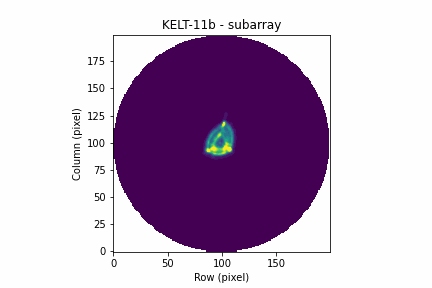

Subarray is saved in the current directory as KELT-11b-subarray.gif


In [4]:
dataset.animate_frames(vmax=0.5)

##### dataset.lc

The items in the dictionary dataset.lc are
- time = BJD-dataset.bjd_ref
- flux = observed flux scaled by its median value 
- flux_err - standard error on flux
- bjd_ref - BJD at the start of the day of observations
- table - astropy table created from binary table stored in the FITS file
- xoff, yoff - offset from nominal target location to measured flux centroid
- contam - fraction of measured flux due to contamination of aperture by other stars
- centroid_x, centroid_y - measured flux centroid position (pixels)
- roll_angle - computed mean roll angle of the CCD
- aperture - aperture radius in pixels

In [5]:
dataset.lc.keys()

dict_keys(['time', 'flux', 'flux_err', 'bjd_ref', 'table', 'header', 'xoff', 'yoff', 'bg', 'contam', 'smear', 'centroid_x', 'centroid_y', 'roll_angle', 'aperture'])

##### Outlier rejection

An initial cut for obvious outliers is applied here. Data points with discrepant fluxes are rejected from all the arrays in dataset.lc _except_ `lc['table']`.  The output of the function is the clipped arrays time, flux, and flux_err.

In [6]:
time,flux,flux_err = dataset.clip_outliers(verbose=True);


Rejected 10 points more than 5.0 x MAD = 942 ppm from the median


#### Diagnostic plot
Useful as a quick-look of the data and meta-data to look for any obvious correlations or problems.

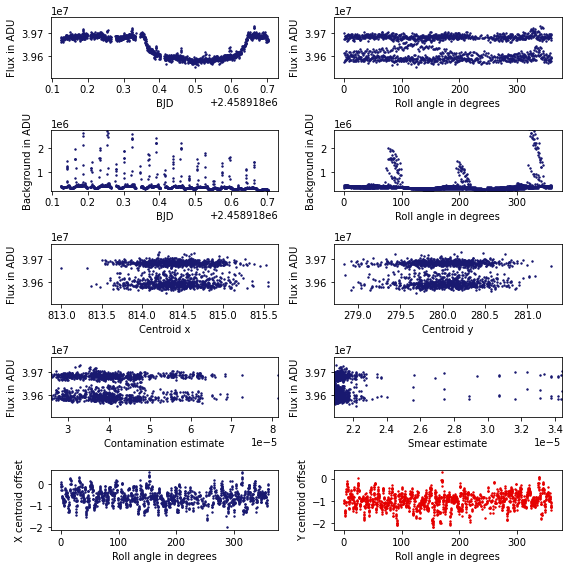

In [7]:
dataset.diagnostic_plot()

##### Make a plot of the data "by-hand"

The plot shows a well-defined transit with a depth of about 0.2% and some little "spikes" that seem to occur regularly - we will deal with these below.

Text(0.5, 1.0, 'KELT-11b')

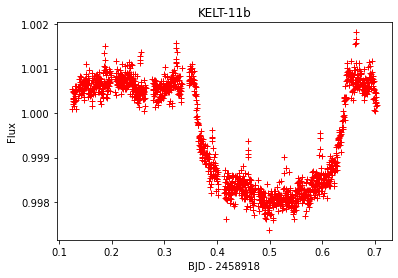

In [8]:
plot(time,flux,'r+') # matplotlib
bjd_ref = dataset.bjd_ref
xlabel(f'BJD - {bjd_ref}') # example of python f-string formatting
ylabel('Flux')
title(dataset.target)

##### Plot of flux against roll-angle
Many of the instrumental artefacts in the CHEOPS light curves are associated with the spacecraft roll angle. In this case we can see the the "spikes" occur near a roll angle of 340 degrees.

Note the use of a temporary variable `t` that "points" to the object we are using in the plot command. 


(0.0, 360.0)

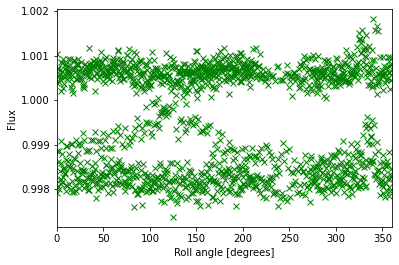

In [9]:
t = dataset.lc
plot(t['roll_angle'],t['flux'],'gx')   # plot with green crosses, just for a change
xlabel('Roll angle [degrees]')
ylabel('Flux')
xlim(0,360)

##### Plot of contamination against roll-angle

Notice in the previous cell that the output from the last command is printed to screen - the semi-colon at the end of the last command here avoids this little issue.

The contamination in this case is a small fraction of the total flux.

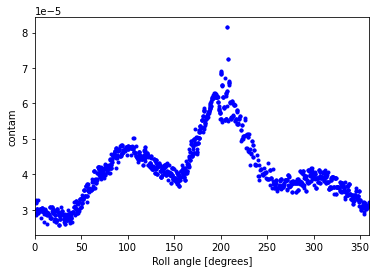

In [10]:
plot(t['roll_angle'],t['contam'],'bo',ms=3)  # blue dots, marker size =3
xlabel('Roll angle [degrees]')
ylabel('contam')
xlim(0,360);

#### Just as an illustration, mask data with x-centroid values < 813.5

 This is only done as an example of how to mask the data - there is no good reason to exclude these data points from the analysis.
 
 As with clip_outliers, all the internal arrays _except_ `lc['table']` are masked.

In [11]:
mask = dataset.lc['centroid_x'] < 813.5
time,flux,flux_err = dataset.mask_data(mask)


Masked 5 points


#### Stellar data
Properties of the star such as Teff and log g are taken from SWEET-Cat. The SWEET-Cat catalogue is downloaded automatically if it is not in your pycheops cache folder, or if the cached version is more than a day old.

The values of Teff, logg and \[Fe/H\] are used to estimate the limb-darkening parameters of the star and the mean stellar density $\rho_{\star}$.

See `help(pycheops.StarProperties)` for instructions on how to specifiy your own values.

CHEOPS Science team members can use the option `dace=True` to use updated values from the StarProperties table stored on DACE.

In [12]:
star = pycheops.StarProperties(dataset.target)  # dace=True
print(star)

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]



#### Least squares fit
The dataset method lmfit_transit uses the Levenberg-Marquardt method implemented in [lmfit](https://lmfit.github.io/lmfit-py/index.html) to find a least-squares best fit for a transit model calculated using the [qpower2](https://ui.adsabs.harvard.edu/abs/2019A%26A...622A..33M/abstract) algorithm.

Parameter values can be specified in various ways
- Fixed value, e.g., P=1.234
- Free parameter with uniform prior interval specified as a 2-tuple, e.g., dfdx=(-1,1). The initial value is taken as the the mid-point of the allowed interval.
- Free parameter with uniform prior interval and initial value specified as a 3-tuple, e.g., (0.1, 0.2, 1)
- Free parameter with a Gaussian prior specified as a [ufloat](https://pythonhosted.org/uncertainties/), e.g., ufloat(0,1). 
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"


To enable decorrelation against a parameter, specifiy it as a free parameter, e.g., dfdbg=(0,1). The decorrelation parameters that are available can be found using `help(pycheops.models.FactorModel)`

Decorrelation is done against is a scaled version of the quantity specified with a range of either (-1,1) or, for strictly positive quantities, (0,1). This means the coefficients dfdx, dfdy, etc.
correspond to the amplitude of the flux variation due to the correlation with the relevant parameter.

Where possible, the initial values for lmfit are taken from the KELT11b PlanetProperties object. These values are stored as ufloat objects. The `.n` attribute of a ufloat is its value and the `.s` attribute is the standard error.


In [13]:
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt

P = Kelt11b.P.n
T0 = Kelt11b.T0.n
cycle = round((dataset.bjd_ref-T0)/P)
T_0 = T0 - dataset.bjd_ref + cycle*P

D = Kelt11b.D.n/1e6  # Depth stored in ppm
W = Kelt11b.W.n/P    # Width stored in days

if Kelt11b.f_c and Kelt11b.f_s:
    f_c = Kelt11b.f_c
    f_s = Kelt11b.f_s
else:
    # From Pepper et al., 2017
    ecosw = ufloat(-0.004,0.05099)
    esinw = ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)

#### Initial fit - no decorrelation
We will use this residuals from this fit to calculate priors on the parameters of the decorrelation model.

There is only one transit in the dataset so the orbital period is fixed for this analysis.

The output from lmfit_transit() is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.


In [14]:
lmfit0 = dataset.lmfit_transit(T_0 = (T_0-0.25,T_0+0.25), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho)

#### Plots of least-squares fit 

- flux values are light blue points
- binned flux values are dark blue error bars
- transit model is the green line
- transit model + trends is the brown line 

Note the ";" at the end of the plot command to stop the plot appearing twice. Alternatively, you can put the output of the plot command (which is a [matplotlib Figure](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure) object) into a variable. This can be used later to save the plot to a file, for example.

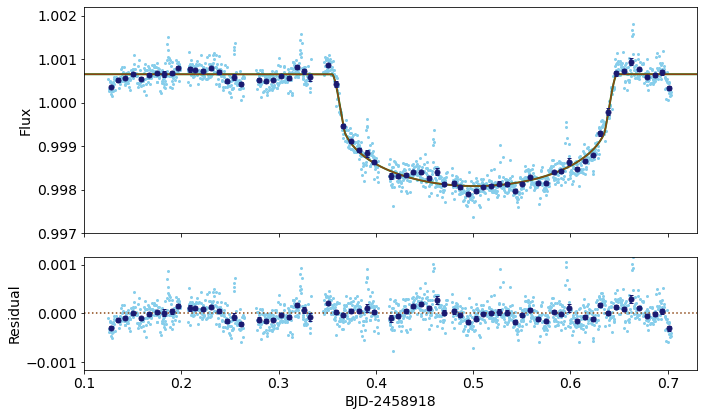

In [15]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14);

#### Prior for decorrelation parameters

Decorrelation is done against is a scaled version of the quantity specified with a range of either (-1,1) or, for strictly positive quantities, (0,1). This means the coefficients dfdx, dfdy, etc.
correspond to the amplitude of the flux variation due to the correlation with the relevant parameter.

A sensible prior for these coefficients (decorrelation parameters) is a normal distribution with the same standard deviation as the residuals from the fit above with no decorrelation. 

Careful selection of the prior is important because it will be used later to determine if we have selected a good set of decorrelation parameters.

In [16]:
sigma_0 = lmfit0.rms
dprior = ufloat(0, sigma_0)
print(f'sigma_0 = {sigma_0:0.6f}')

sigma_0 = 0.000233


#### Transit fit with lmfit including decorrelation
`dfdt` is a linear trend with time and `dfdcontam` is a linear trend v. the contamination of the aperture by nearby stars. The contamination is estimated using the Gaia catalogue. If `decontaminate=True` is used in get_lightcurve() then this value is subtracted from the measured flux, so this value should be close to zero. 

In [17]:
# Update T_0 from previous fit as a starting point
T_0 = lmfit0.params['T_0'].value
lmfit = dataset.lmfit_transit(T_0 = (T_0-0.01,T_0+0.01), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s,  
                      h_1=star.h_1, h_2=star.h_2.n,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      dfdt=dprior, dfdcontam=dprior,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 265
    # data points      = 1505
    # variables        = 16
    chi-square         = 2903.63184
    reduced chi-square = 1.95005496
    Akaike info crit   = 1021.03997
    Bayesian info crit = 1106.10474
    RMS residual       = 223.8 ppm
[[Variables]]
    T_0:         0.50146814 +/- 0.04431829 (8.84%) (init = 0.5018605)
    P:           4.736525 (fixed)
    D:           0.00218804 +/- 3.1578e-05 (1.44%) (init = 0.00267)
    W:           0.06502399 +/- 0.00355457 (5.47%) (init = 0.06424541)
    b:           0.50032212 +/- 0.01088374 (2.18%) (init = 0.5)
    f_c:        -0.02503862 +/- 0.12391559 (494.90%) (init = -0.02262488)
    f_s:         0.28991412 +/- 0.13576573 (46.83%) (init = 0.1753428)
    h_1:         0.69542939 +/- 0.00814029 (1.17%) (init = 0.715)
    h_2:         0.442 (fixed)
    c:           1.00073182 +/- 3.2202e-05 (0.00%) (init = 1)
    dfdcontam:  -2.8713e-04 +/- 1.1071e-04 (38.56%) (init

##### Model selection

The question of which decorrelation parameters to include is an example of model selection. In this case we have nested models in which one or more of the parameters is fixed in the simpler model.

For models $M_0$ and $M_1$ with parameters $\theta_0 = \{p_1, p_2, \dots, p_n, 0\}$ and $\theta_1 = \{p_1, p_2, \dots, p_n, \psi\}$, given the data $D$, the Bayes factor $B_{01}$ is defined by  

$$ \frac{P(M_0|D)}{P(M_1|D)} = \frac{P(M_0)}{P(M_1)} \frac{P(D|M_0)}{D|P(M_1)} = \frac{P(M_0)}{P(M_1)} B_{01},$$
where
$ P(D|M_0) = \int P(D|\theta_0)P(\theta_0)d^n\theta$ and similarly for $P(D|M_1)$. $P(\theta_0)$ is the prior on the parameters of model $M_0$.

The prior on the extra parameter are the same for both models so we can use the Savage-Dickey Density Ratio to calculate the Bayes factor
$$ B_{01} = \frac{P(\psi=0|D)}{P(\psi=0)} $$

For a normal prior with standard deviation $\sigma_0$, $P(\psi=0) = 1/\sigma_0\sqrt{2\pi}$.

The posterior probability distributions for the decorrelation parameters are normally well-behaved and close to Gaussian, as expected for a linear model. Assuming that they are normally distributed and that the standard deviation is given accurately by the error on the parameter given by lmfit, and that *a priori* the two models are equally likely, we can calculate Bayes factor for models with/without parameter with value $p\pm\sigma_p$ from lmfit using

$$B_p = e^{-(p/\sigma_p)^2/2}\sigma_0/\sigma_p$$

These are the values listed in the section \[\[Bayes Factors\]\] in the report above. Parameters with Bayes factors $\overset{>}{\sim} 1$  are not supported by the data and can be removed from the model. In this example we can safely remove `dftdt`. We could instead remove `dfdsin2phi`, but we will keep it because it is one of a set. 


**N.B.** this statistic is only valid for comparison of the models with/without one parameter, so parameters should be removed one-by-one and the test repeated for every new pair of models.



For a derivation of the Savage-Dickey Density Ratio see  Trotta [2007MNRAS.378...72T](https://ui.adsabs.harvard.edu/abs/2007MNRAS.378...72T/abstract)

#### Re-run lmfit without dfdt

In [18]:
lmfit = dataset.lmfit_transit(T_0 = (T_0-0.01,T_0+0.01), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 281
    # data points      = 1503
    # variables        = 14
    chi-square         = 2940.26213
    reduced chi-square = 1.97465556
    Akaike info crit   = 1036.56655
    Bayesian info crit = 1110.97960
    RMS residual       = 225.3 ppm
[[Variables]]
    T_0:         0.50112823 +/- 0.01691402 (3.38%) (init = 0.5018605)
    P:           4.736525 (fixed)
    D:           0.00229341 +/- 4.1812e-05 (1.82%) (init = 0.00267)
    W:           0.06271846 +/- 0.00182909 (2.92%) (init = 0.06424541)
    b:           0.61718416 +/- 0.04820169 (7.81%) (init = 0.5)
    f_c:        -0.08521278 +/- 0.12817380 (150.42%) (init = -0.02262488)
    f_s:         0.20132051 +/- 0.15582935 (77.40%) (init = 0.1753428)
    h_1:         0.70393697 +/- 0.00877503 (1.25%) (init = 0.715)
    h_2:         0.442 (fixed)
    c:           1.00064200 +/- 8.6289e-06 (0.00%) (init = 1)
    dfdsinphi:   1.1087e-05 +/- 9.1183e-06 (82.24%) (init

#### Plots of least-squares fit  after de-trending the data 
In this plot (detrend=True) 
- (flux/trend) values are light blue points
- binned (flux/trend) values are dark blue error bars
- transit model is the green line
- transit model/trend is the brown line (same as green line in this case) 

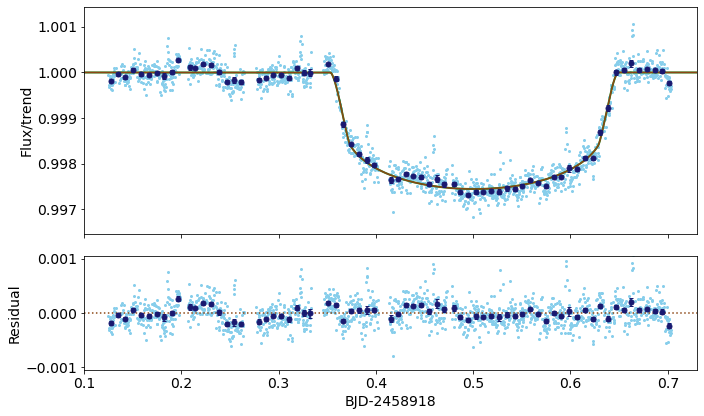

In [19]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True);

#### Roll angle plot
Same color-coding of data and models as before. 

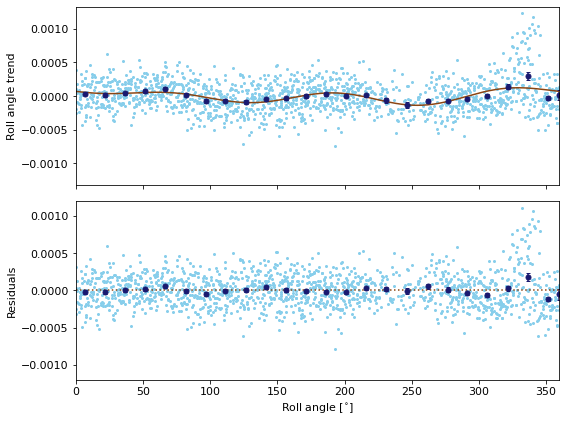

In [20]:
fig = dataset.rollangle_plot()

#### Try modelling excess flux near roll angle 340$^{\circ}$ as internal reflection ("glint")

The method `add_glint()` is being used here to calculate a spline fit to the residuals from the last fit. A scaled version of this function (which is stored in dataset) can then be added to the model. 

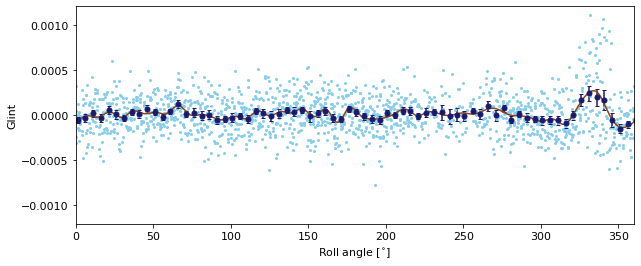

In [21]:
glint_func = dataset.add_glint(nspline=48,binwidth=5,figsize=(10,4),gapmax=5)

#### Fit including glint
The parameter glint_scale includes a linear scaling of the glint function we created as part of the model. Here we allow the glint to be scaled between 0 (no glint) and 2 (twice as much glint as estimated from the previous fit).

In [22]:
dataset.lmfit_transit(T_0 = (T_0-0.01,T_0+0.01), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      dfdcontam=dprior,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      glint_scale=(0,2),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 373
    # data points      = 1505
    # variables        = 17
    chi-square         = 2681.04211
    reduced chi-square = 1.80177561
    Akaike info crit   = 903.006067
    Bayesian info crit = 993.387386
    RMS residual       = 214.9 ppm
[[Variables]]
    T_0:          0.50126185 +/- 1.60457414 (320.11%) (init = 0.5018605)
    P:            4.736525 (fixed)
    D:            0.00218644 +/- 2.9140e-05 (1.33%) (init = 0.00267)
    W:            0.06324510 +/- 0.00292270 (4.62%) (init = 0.06424541)
    b:            0.49852598 +/- 0.00831237 (1.67%) (init = 0.5)
    f_c:         -0.01707179 +/- 0.12094570 (708.45%) (init = -0.02262488)
    f_s:          0.21440864 +/- 0.15904177 (74.18%) (init = 0.1753428)
    h_1:          0.69738784 +/- 0.00806011 (1.16%) (init = 0.715)
    h_2:          0.45548415 +/- 0.06199863 (13.61%) (init = 0.442)
    c:            1.00065605 +/- 3.1596e-05 (0.00%) (init = 1)
    dfdco

#### Plot the results


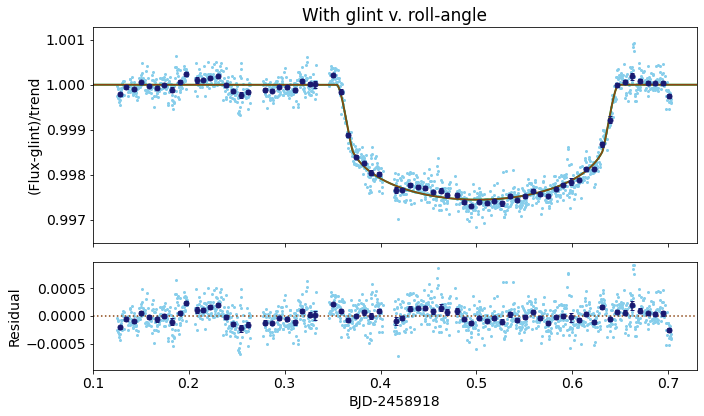

In [23]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                   title='With glint v. roll-angle');

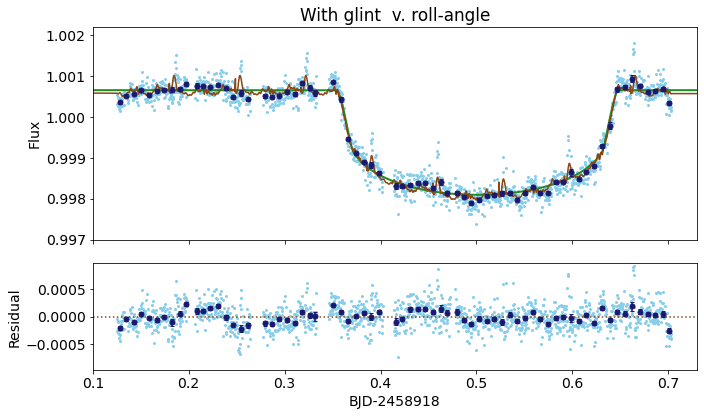

In [24]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                   title='With glint  v. roll-angle');

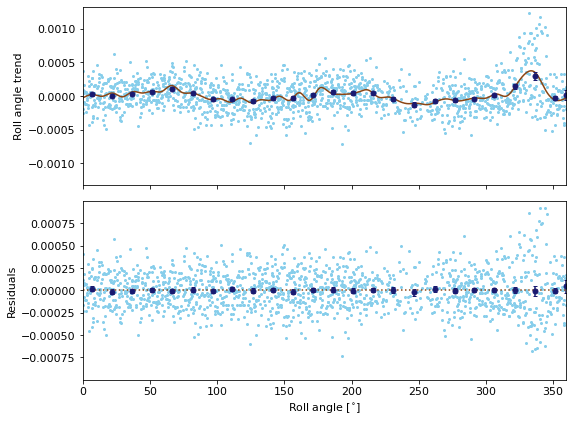

In [25]:
fig = dataset.rollangle_plot()

##### Glint correction for internal reflection from the Moon.
The previous fit is better, but the extra flux does not appear at exactly the same roll angle every time. The reason from this can be found by checking for solar system objects near the field of view. We see that the Moon was only 16$^{\circ}$ from the target. The position of the Moon varies noticeably during the observation, so we must account for this when we model the glint.

In [26]:
dataset.planet_check()

BJD = 2458918.125228298
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     11:21:45.98  +09:19:22.6      16.0
Mars     19:05:24.63  -23:08:37.9      81.6
Jupiter  19:29:58.35  -21:50:58.1     113.6
Saturn   20:03:17.22  -20:27:01.5     125.8
Uranus   02:06:47.07  +12:20:30.2     129.0
Neptune  23:18:02.80  -05:36:58.0     163.1


#### Try modelling excess flux near roll angle 340 as Moon glint

Residuals from last fit will already be corrected for glint, so we can either re-run lmfit without `glint_scale` and re-fit, or just fit the out-of transit flux. 

For this example, let's create a mask so that we can fit the out-of-transit flux.


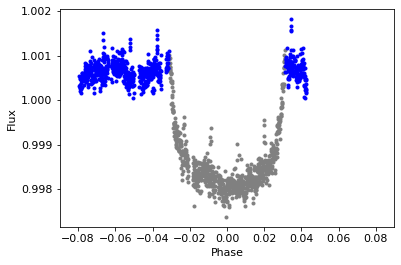

In [27]:
from pycheops.utils import phaser
phase = phaser(time,lmfit.params['P'],lmfit.params['T_0'],-0.5)
mask = abs(phase) < lmfit.params['W']/2
plot(phase[mask],flux[mask],'.',color='gray')
plot(phase[~mask],flux[~mask],'.',color='blue')
xlim(-0.09,0.09)
xlabel('Phase')
ylabel('Flux');

##### Creating glint function v. moon angle
- using fit_flux to fit flux values, not residuals
- using mask=mask to use mask created above to exclude in-transit data
- using moon=True to account for motion of the Moon

The previous glint function is overwritten by this new glint function.

Note the the spike v. Moon angle is sharper than against roll angle.

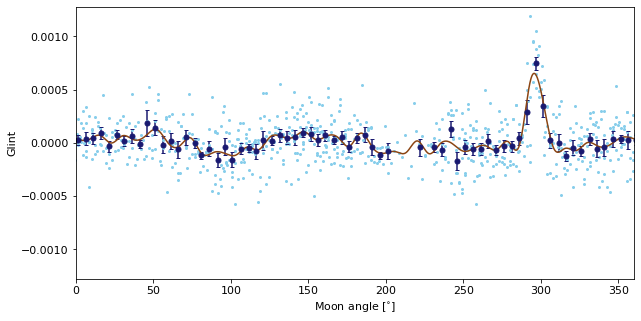

In [28]:
moon_glint = dataset.add_glint(moon=True,nspline=48,binwidth=5,
                               fit_flux=True, mask=mask,
                              figsize=(10,5))

##### Least-squares fit including glint v. moon angle

In [29]:
dataset.lmfit_transit(T_0 = (T_0-0.01,T_0+0.01), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s,
                      dfdcontam=dprior,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      dfdsin2phi=dprior,dfdcos2phi=dprior,
                      dfdsin3phi=dprior,dfdcos3phi=dprior,
                      glint_scale=(0,2),
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 350
    # data points      = 1505
    # variables        = 17
    chi-square         = 2437.20663
    reduced chi-square = 1.63790768
    Akaike info crit   = 759.499791
    Bayesian info crit = 849.881110
    RMS residual       = 204.6 ppm
[[Variables]]
    T_0:          0.50138154 +/- 0.23033417 (45.94%) (init = 0.5018605)
    P:            4.736525 (fixed)
    D:            0.00214538 +/- 3.7456e-05 (1.75%) (init = 0.00267)
    W:            0.06590597 +/- 0.00382667 (5.81%) (init = 0.06424541)
    b:            0.46983411 +/- 0.04590315 (9.77%) (init = 0.5)
    f_c:         -0.03784591 +/- 0.10179936 (268.98%) (init = -0.02262488)
    f_s:          0.31292398 +/- 0.12336708 (39.42%) (init = 0.1753428)
    h_1:          0.69395420 +/- 0.00753429 (1.09%) (init = 0.715)
    h_2:          0.47560617 +/- 0.05975513 (12.56%) (init = 0.442)
    c:            1.00065063 +/- 2.9900e-05 (0.00%) (init = 1)
    dfdcon

#### Simplify model
 The previous lmfit shows that we can simplify the model by removing one of the free parameters with a large Bayes factors. Doing this one-by-one shows that the glint function by itself is sufficient to remove the trends. In principle, we could remove all the decorrelation parameters apart from `glint_scale`. However, for this example we will keep  `dfdsinphi` and `dfdcosphi`. This will enable us to see the correlation between these parameters, and will be used to illustrate some features on the Multivisit method in another notebook. 

In [30]:
dataset.lmfit_transit(T_0 = (T_0-0.01,T_0+0.01), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s,
                      dfdsinphi=dprior,dfdcosphi=dprior,
                      glint_scale=(0,2),
                      h_1=star.h_1, h_2=star.h_2,logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 340
    # data points      = 1500
    # variables        = 12
    chi-square         = 2456.47097
    reduced chi-square = 1.65085415
    Akaike info crit   = 763.890970
    Bayesian info crit = 827.649614
    RMS residual       = 205.4 ppm
[[Variables]]
    T_0:          0.50128283 +/- 0.02395002 (4.78%) (init = 0.5018605)
    P:            4.736525 (fixed)
    D:            0.00220406 +/- 3.8065e-05 (1.73%) (init = 0.00267)
    W:            0.06398628 +/- 0.00271099 (4.24%) (init = 0.06424541)
    b:            0.53602163 +/- 0.03059770 (5.71%) (init = 0.5)
    f_c:         -0.02214797 +/- 0.01980591 (89.43%) (init = -0.02262488)
    f_s:          0.25437650 +/- 0.13480318 (52.99%) (init = 0.1753428)
    h_1:          0.69581244 +/- 0.00773972 (1.11%) (init = 0.715)
    h_2:          0.46103315 +/- 0.05982425 (12.98%) (init = 0.442)
    c:            1.00063483 +/- 7.7883e-06 (0.00%) (init = 1)
    dfdsinph

In [31]:
for p in dataset.lmfit.params:
    print(p, p == 'glint_scale')

T_0 False
P False
D False
W False
b False
f_c False
f_s False
h_1 False
h_2 False
c False
dfdsinphi False
dfdcosphi False
glint_scale True
k False
aR False
sini False
logrho False
e False
q_1 False
q_2 False


##### Plot the results.

Note that for the roll angle plot there are now 3 panels. The residuals in the top panel are corrected for glint but not for other trends - the model for these is shown in brown. The fit of the glint function to the residuals corrected for other trends is shown the middle panel. The lower panel shows the residuals from the complete model, i.e., flux - (transit $\times$ trends + glint)

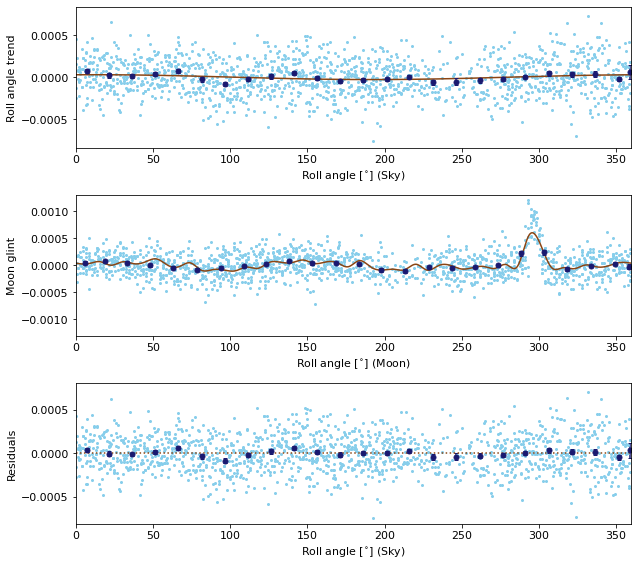

In [32]:
fig = dataset.rollangle_plot()

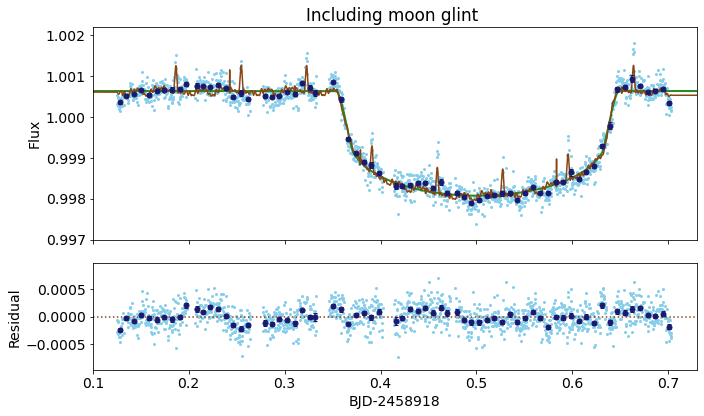

In [33]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                  title='Including moon glint ');

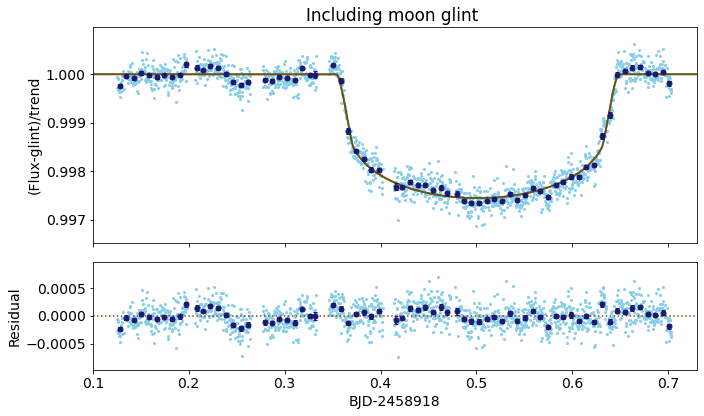

In [34]:
dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                  title='Including moon glint ');

#### GP fit with fixed transit parameters

The "bumps-and-wiggles" in the residuals from the previous fit are very likely to be due to real flux variations from the star due to convection in its atmosphere a.k.a. granulation noise or "flicker" ([Sulis et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..70S/abstract)). The time scale ($\sim$ hour) and amplitude ($\sim 100$ppm) of the variation are typical granulation noise observed in other cool sub-giant stars. 

A Gaussian Process (GP) is a way to model the granulation noise by specifying the properties of the correlation matrix for this correlated noise. We will use the [`celerite`](https://celerite.readthedocs.io/en/stable/) package to do this because it can do the calculation of the likelihood for a given noise function very quickly, and it includes a kernel that is appropriate for granulation noise. 


Our noise model will then have three components
- Gaussian white noise with standard deviation per-point given by `flux_err`.
- Extra Gaussian white noise ("jitter") with standard deviation per-point $\sigma$
- Correlated noise described by a GP calculated using the [SHOTerm](https://celerite.readthedocs.io/en/stable/python/kernel/?highlight=shoterm#celerite.terms.SHOTerm) kernel in celerite with fixed shape parameter $Q=1/\sqrt{2}$.

With $Q=1/\sqrt{2}$, the kernel that describes the covariance between observations separated by a time $\tau$ is 
$$ k(\tau) = S_0\omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(\omega_0\tau/\sqrt{2} - \pi/4\right)$$

The free parameters of the noise model are then $\sigma$ (amplitude of the jitter), $\omega_0$ (related to correlation time scale) and $S_0$ (related to amplitude of the correlated noise). These are all strictly positive values for which we want to use a scale-free prior so we use the log of these values when we sample the posterior probability distribution (PPD). The sampling of the PPD is done using [emcee](https://emcee.readthedocs.io/en/stable/).


Directly fitting a GP to the data with all the transit and decorrelation parameters as free parameters leads to large errors on the transit parameters and a GP that implies much more variability in the flux than is seen in CHEOPS data for similar stars, i.e., the GP tries to model the transit as noise. To avoid this, we first do a GP fit with the transit parameters fixed. The results from this fit are used to put priors on the parameters of the noise model in the final fit.


In [35]:
# Copy the parameters from the last lmfit
params_fixed = dataset.lmfit.params.copy() 

# Fix the transit parameters
for p in ['T_0','D','W','b']:
    params_fixed[p].set(vary=False)

# Use emcee to sample the PPD. Note we add the SHOTerm at this step.
result = dataset.emcee_sampler(params=params_fixed, add_shoterm=True, 
                               burn=512,steps=256,nwalkers=128)

print(dataset.emcee_report(min_correl=0.5))


Running burn-in ..


100%|██████████| 512/512 [07:30<00:00,  1.14it/s]

Running sampler ..



100%|██████████| 256/256 [03:36<00:00,  1.18it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 97978
    # data points      = 1493
    # variables        = 11
    chi-square         = 2464.30166
    reduced chi-square = 1.66282163
    Akaike info crit   = -21394.8060
    Bayesian info crit = -21336.4121
    RMS residual       = 205.9 ppm
[[Variables]]
    T_0:          0.5012828 (fixed)
    P:            4.736525 (fixed)
    D:            0.002204059 (fixed)
    W:            0.06398628 (fixed)
    b:            0.5360216 (fixed)
    f_c:         -0.10754176 +/- 0.23186623 (215.61%) (init = -0.02262488)
    f_s:          0.22024256 +/- 0.05396046 (24.50%) (init = 0.1753428)
    h_1:          0.70992620 +/- 0.01009539 (1.42%) (init = 0.715)
    h_2:          0.45003777 +/- 0.04653135 (10.34%) (init = 0.442)
    c:            1.00063521 +/- 1.7457e-05 (0.00%) (init = 1)
    dfdsinphi:    5.7167e-06 +/- 2.4976e-05 (436.89%) (init = 0)
    dfdcosphi:    2.3034e-05 +/- 2.5218e-05 (109.48%) (init = 0)
    glint

##### Plot of emcee fit including a GP noise model - no de-trending
With detrend=False (the default) the upper panel shows the unbinned and binned flux values used in the fit (light blue and dark blue, as before), the transit model (green) and the best-fit (maximum likelihood) model including all trends, glint and the GP noise model. Several samples from the PPD are used to plot other models that give a reasonable fit to the data in light brown. 

The lower panel shows the residuals from non-GP parts of the model, i.e., flux - (transit $\times$ trends + glint). The GP noise model is shown in brown.

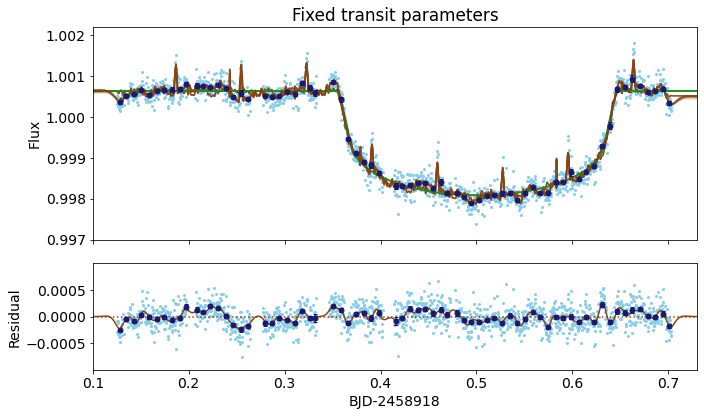

In [36]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14,
                          title='Fixed transit parameters')

##### Plot of emcee fit including a GP noise model - with de-trending
With detrend=True, the flux values in the upper panel have been corrected for instrumental trends and glint. The transit model is shown in green, and the transit model + GP noise models are shown in brown (best-fit and samples, as before). The residuals are plotted in the lower panel in the same way as for detrend=False.

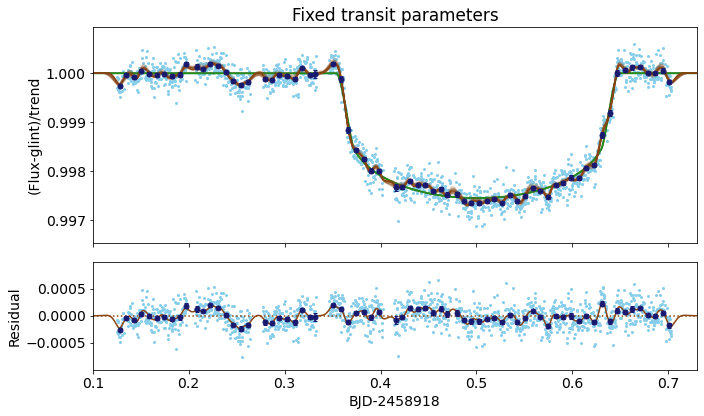

In [37]:
fig = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                          title='Fixed transit parameters')

#### Complete emcee sampler run with priors  

We now create Gaussian priors on the noise model parameters centered on the mean of the PPD from the previous fit, and the standard deviation is set to twice the width the PPD. This keeps the noise model in a reasonable region of its parameter space while allowing us to explore if the transit model parameters depend strongly on the noise model. This is done by setting the user_data attribute of the [lmfit Parameter object](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) to a [ufloat](https://pythonhosted.org/uncertainties/) value.

We already added the SHOTerm to the model in the previous step so we do not need to include "add_shoterm" in the call to emcee_sampler again. The output from this emcee run will overwrite the previous results stored in the dataset object. We are also over-writing the "result" variable that stores the output from the previous emcee run as an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) object - we could give the result a different variable name here if we want to save those results.


In [38]:
# Get a copy of the parameters from the previous emcee run
params_prior = dataset.emcee.params.copy()

# Setting the noise model parameters
from uncertainties import ufloat
for p in ['log_S0', 'log_omega0', 'log_sigma']:
    params_prior[p].user_data=ufloat(params_prior[p].value,2*params_prior[p].stderr)

# Restoring the transit model parameters as free parameters
for p in ['T_0','D','W','b']:
    params_prior[p].set(vary=True)
    
# Run emcee again
result = dataset.emcee_sampler(params=params_prior, burn=512, steps=256, nwalkers=256)
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 512/512 [14:28<00:00,  1.70s/it]

Running sampler ..



100%|██████████| 256/256 [07:05<00:00,  1.66s/it]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 268033
    # data points      = 1493
    # variables        = 15
    chi-square         = 2532.54377
    reduced chi-square = 1.71349376
    Akaike info crit   = -21391.0542
    Bayesian info crit = -21311.4260
    RMS residual       = 208.5 ppm
[[Variables]]
    T_0:          0.50195486 +/- 7.0261e-04 (0.14%) (init = 0.5018605)
    P:            4.736525 (fixed)
    D:            0.00209277 +/- 6.7241e-05 (3.21%) (init = 0.00267)
    W:            0.06333671 +/- 0.00213335 (3.37%) (init = 0.06424541)
    b:            0.31958829 +/- 0.14604888 (45.70%) (init = 0.5)
    f_c:         -0.04564339 +/- 0.19266849 (422.12%) (init = -0.02262488)
    f_s:          0.15059768 +/- 0.12282737 (81.56%) (init = 0.1753428)
    h_1:          0.70784880 +/- 0.01054405 (1.49%) (init = 0.715)
    h_2:          0.45162089 +/- 0.05073670 (11.23%) (init = 0.442)
    c:            1.00063574 +/- 2.4737e-05 (0.00%) (init = 1)
    dfd

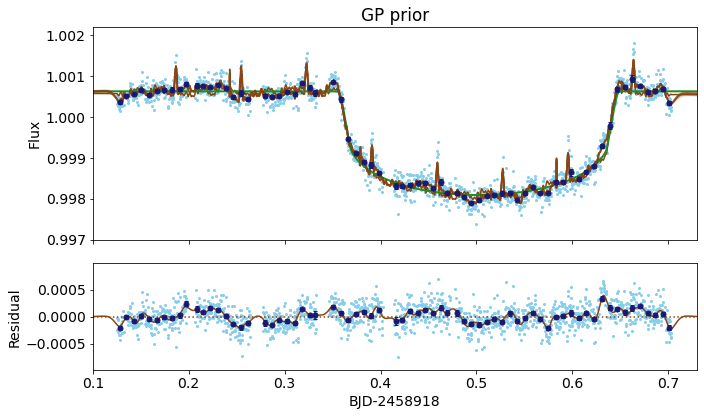

In [39]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                          title='GP prior')

#### Here we save a the plot of the final fit to the light curve as a file

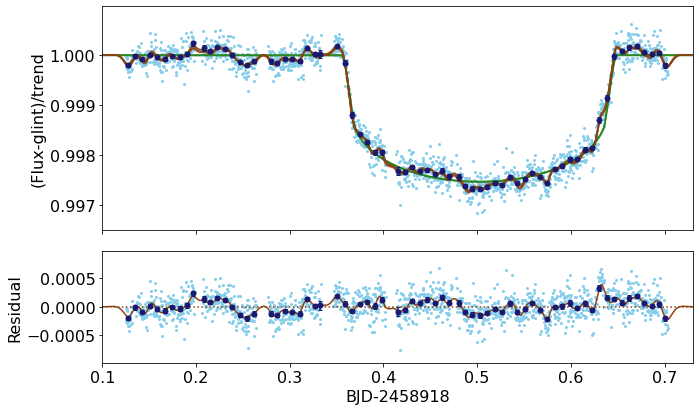

In [40]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=16, detrend=True)
fig.savefig('kelt11fig.png')

#### Corner plots
We can use a corner plot to view correlations between model parameters. Gaussian priors on parameters are shown using dashed-green lines to indicate the $\pm$ 1-sigma limits. In this first corner plot we can see how the PPD of the noise model parameters are narrower than their priors, i.e., the noise models are still being determined mostly by the data and the priors are only preventing these parameters from going to very large or small values.  

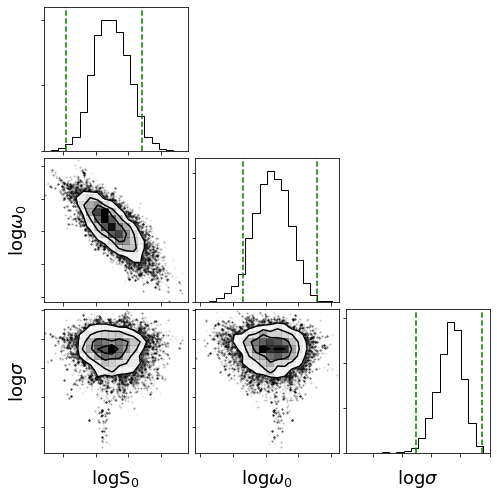

In [41]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 18}
fig = dataset.corner_plot(
    plotkeys=['log_S0','log_omega0','log_sigma'],
    kwargs={'label_kwargs':{'fontdict':font}})

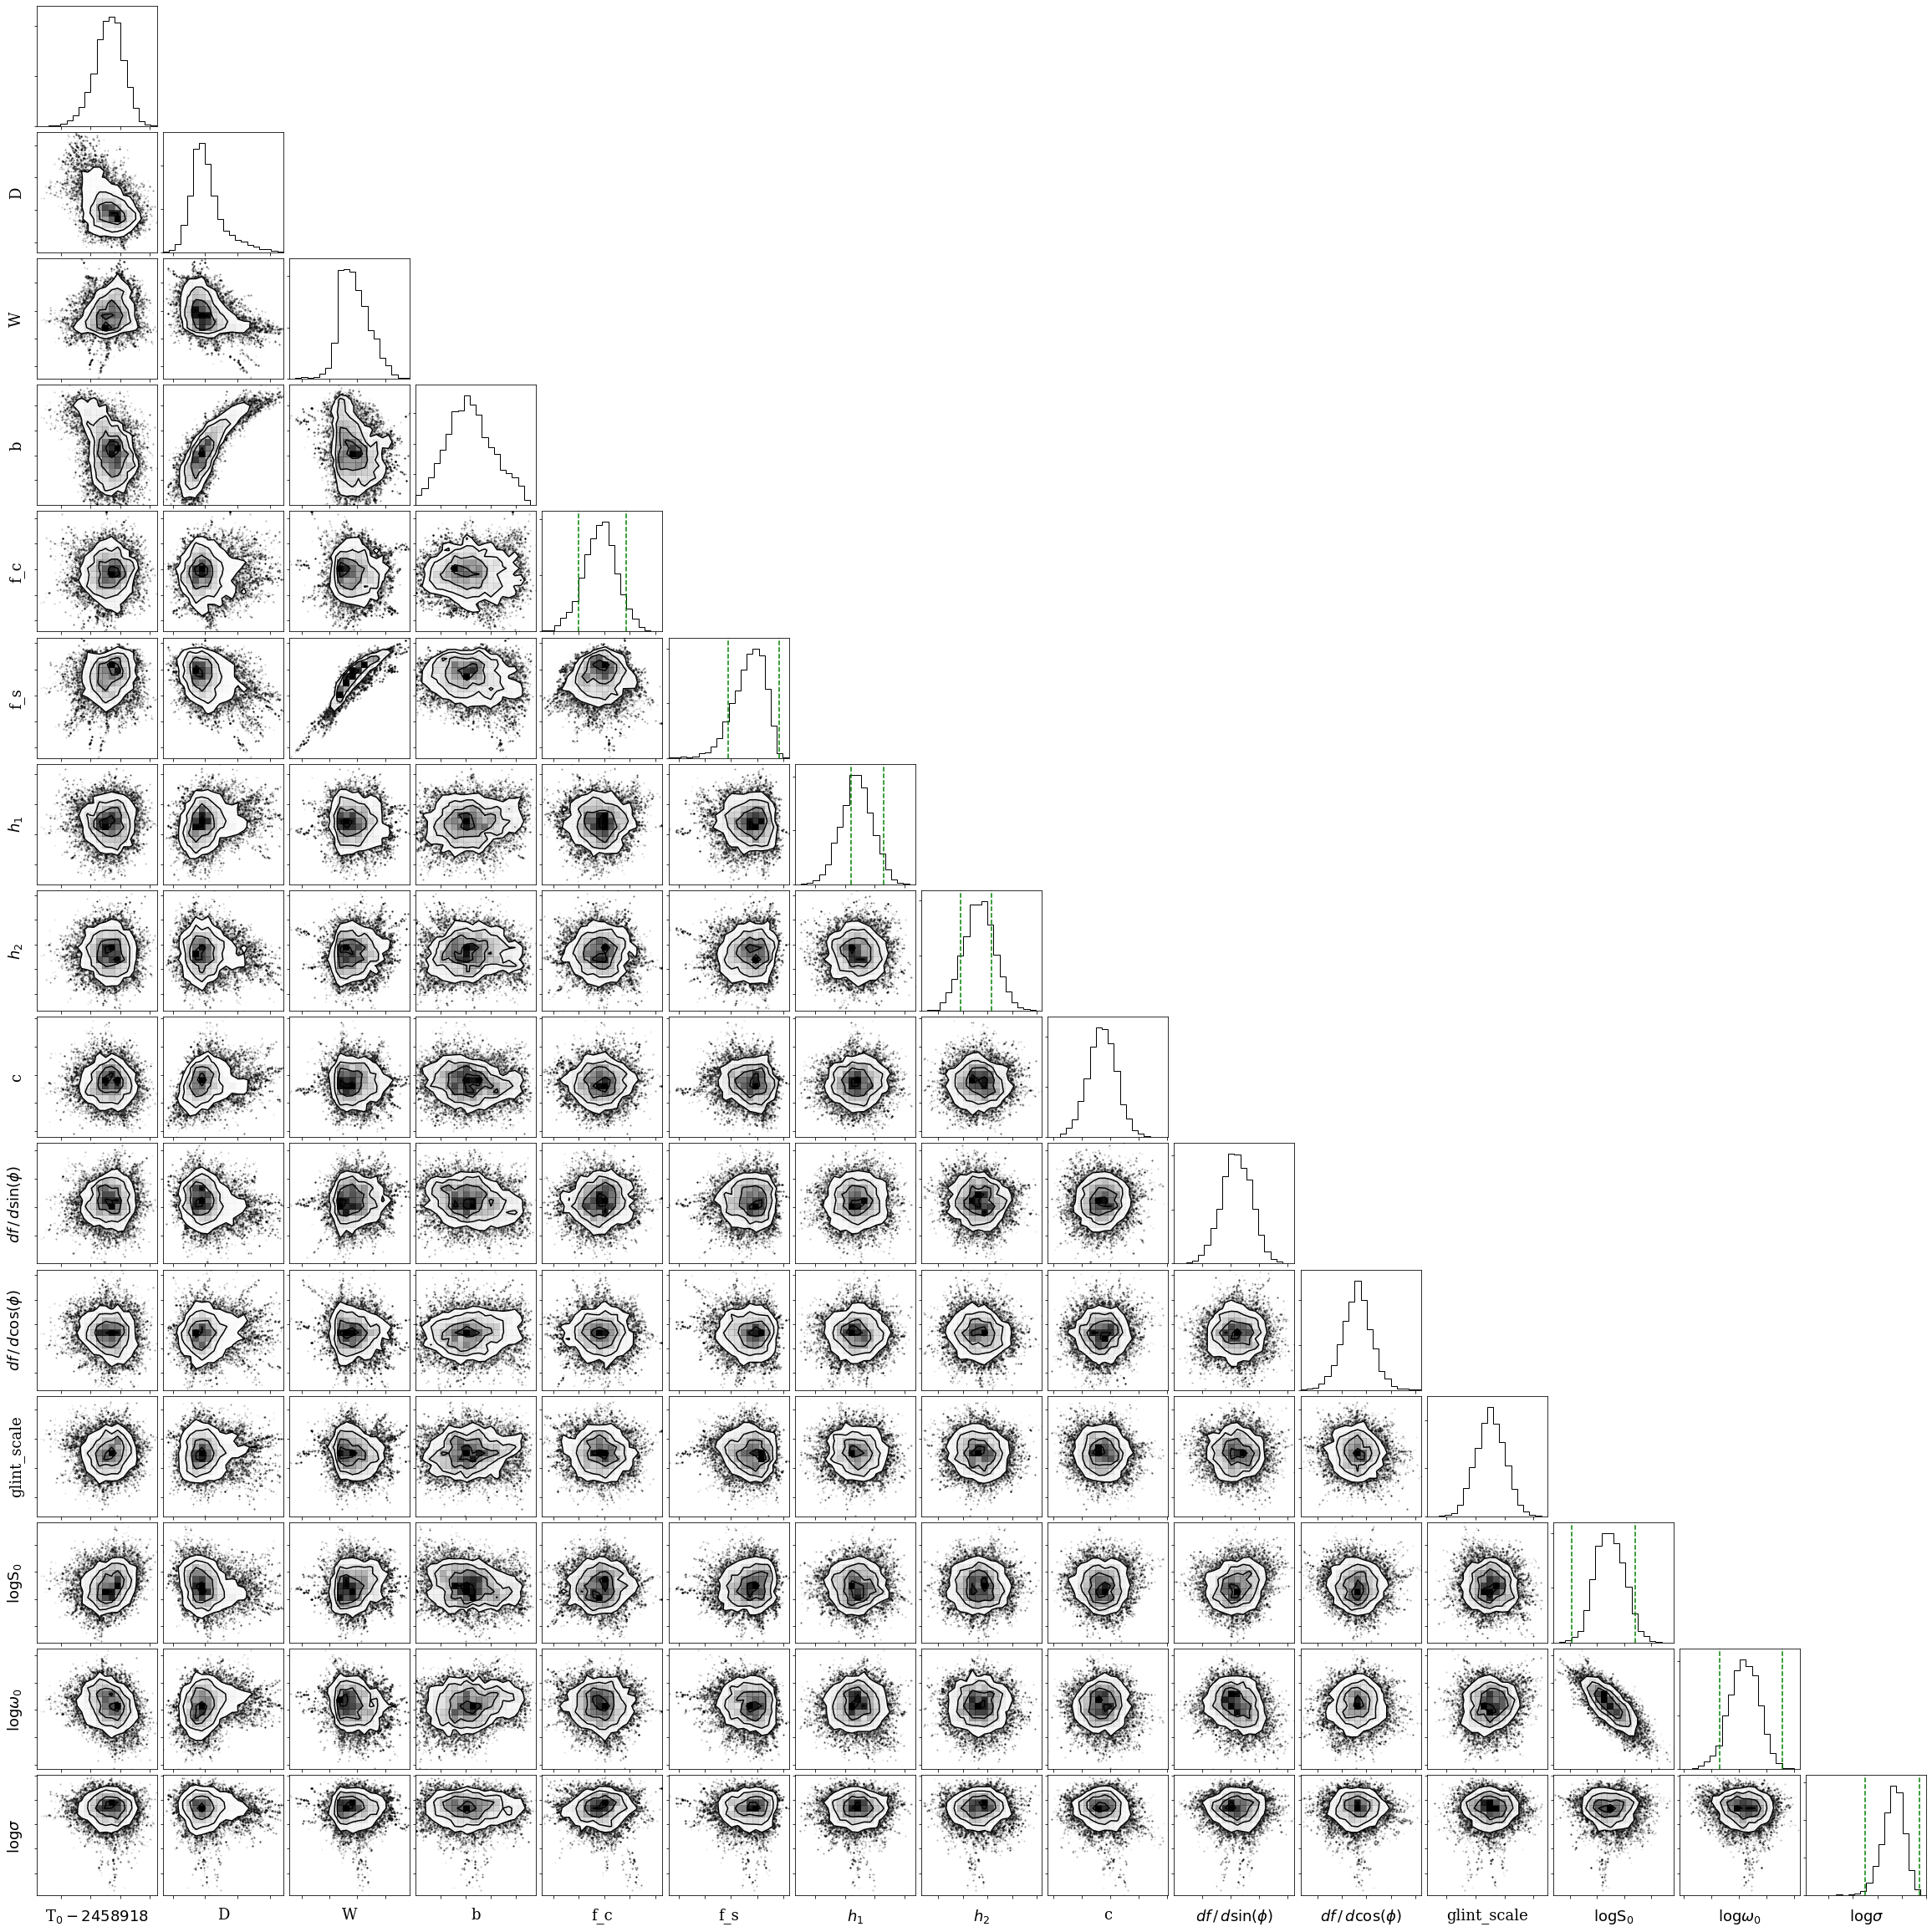

In [42]:
fig = dataset.corner_plot(plotkeys='all',kwargs={'label_kwargs':{'fontdict':font}})

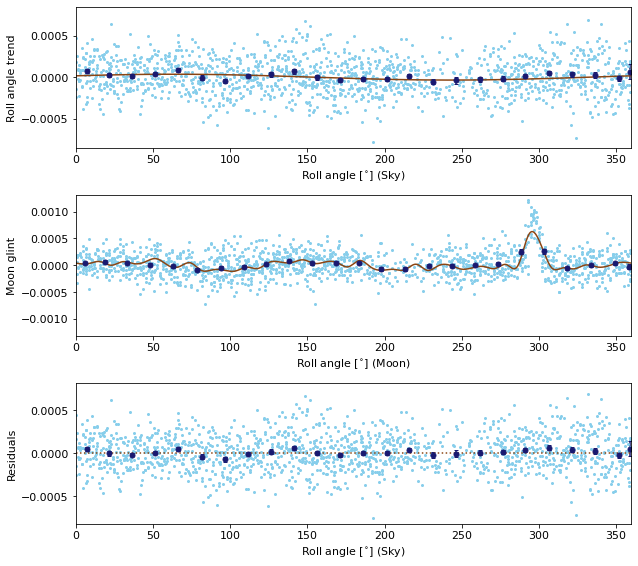

In [43]:
fig = dataset.rollangle_plot()

#### Trail plot
A trail plot is shows the parameter values v. step number for all the walkers in the sampler. This is a very effective way to check that the sampler has converged, i.e., that the sampler is randomly sampling the posterior probability distribution. 

In a "well-mixed" chain, the trail plot will look like noise for all the walkers and there will be no trends in the position or width of the trails.

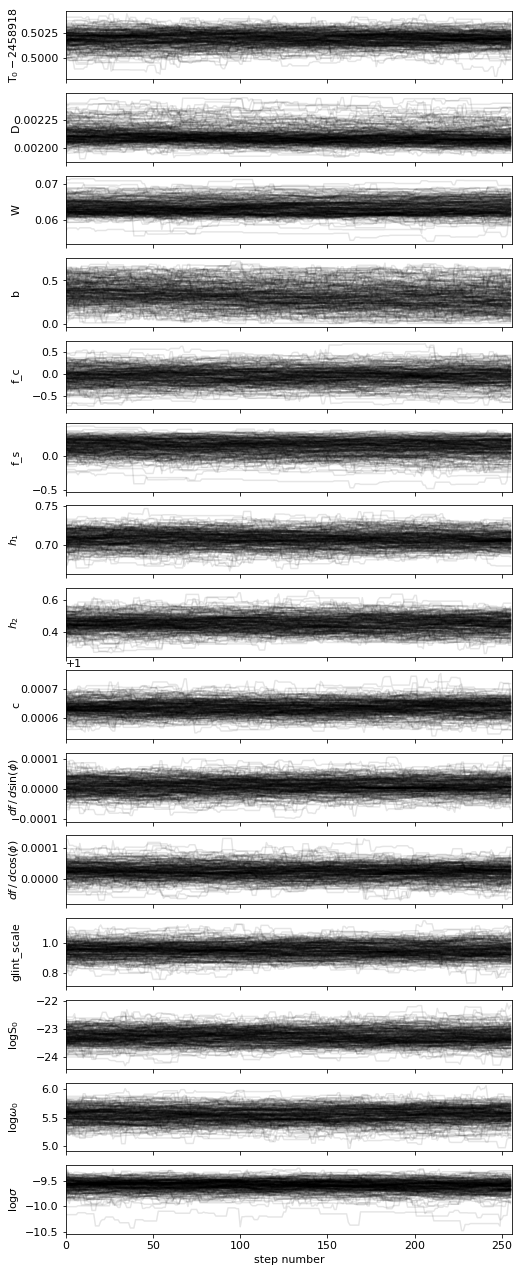

In [44]:
fig = dataset.trail_plot('all')

#### FFT of the residuals
Lomb-Scargle power-spectrum of the residuals. 

The previous fit included a GP which is _not_ included in the calculation of the residuals, i.e., the power spectrum includes the power "fitted-out" using the GP. The assumption here is that the GP has been used to model stellar variability that we wish to characterize using the power spectrum.

The red vertical dotted lines show the CHEOPS  orbital frequency and its first two harmonics.

The likely range of $\nu_{\rm max}$ (peak power for stellar oscillation) is shown using green dashed lines.

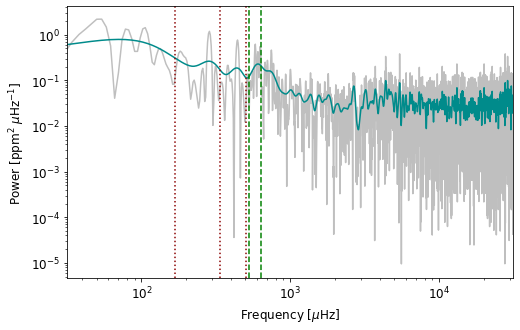

In [45]:
fig = dataset.plot_fft(star, gsmooth=10)

### Mass-radius plot
Once we are happy with the fit to the transit light curve we can use the parameters derived to calculate the mass and radius of the planet. To do this we need to specify the semi-amplitude of the star's orbit due to the planet (K in m/s) and provide the star's mass and/or radius. If only the mass is provided then the radius is calculated from the stellar density obtained from the transit width, and vice versa. 

For more details on the options in dataset.massradius, see the inline help for `pycheops.funcs.massradius`.


[[Mass/radius]]
    m_star   =      1.440 +/-      0.060 (    -0.060,    +0.060) M_Sun
    r_star   =       2.71 +/-       0.16 (     -0.13,     +0.18) R_Sun
    e        =      0.062 +/-      0.051 (    -0.042,    +0.060)
    r_p      =      13.52 +/-       0.92 (     -0.72,     +1.13) R_Earth
    m_p      =       61.8 +/-        6.0 (      -5.9,      +6.0) M_Earth
    q        =   0.000129 +/-   0.000012 ( -0.000012, +0.000012)
    a        =      13.40 +/-       0.19 (     -0.19,     +0.18) R_Sun
    a        =    0.06233 +/-    0.00087 (  -0.00088,  +0.00086) au
    rho_star =      0.072 +/-      0.012 (    -0.012,    +0.011) rho_Sun
    g_p      =       3.28 +/-       0.52 (     -0.53,     +0.50) m.s-2
    log g_p  =      2.516 +/-      0.069 (    -0.077,    +0.062) [cgs]
    rho_p    =     0.0247 +/-     0.0052 (   -0.0054,   +0.0050) rho_Earth
    rho_p    =      0.136 +/-      0.029 (    -0.030,    +0.028) [g.cm-3]


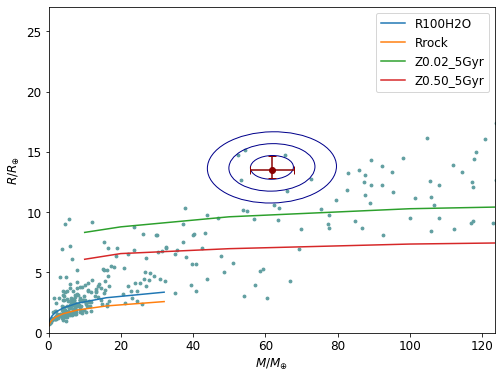

In [46]:
r,fig=dataset.massradius(m_star=(1.44, 0.06), K=(18.5,1.7),jovian=False)
fig.savefig('KELT-11b_massradius.png')

#### Save the dataset
This will save all the data and results from the last least-squares fit and the last emcee fit.

In [47]:
dataset.save();

### MultiVisit
MultiVisit can be used to analyse one of more datasets previously saved from pycheops. 


The fit *automagically* includes the following model to account for trends in the data correlated with roll angle: $$\sum_{j=1}^n \alpha_j\sin(j\cdot\Omega t) + \beta_j\cos(j\cdot\Omega t),$$
where, $\Omega$ is the angular rotation frequency of the spacecraft. The free parameters $\alpha_j$ and $\beta_j$ are never calculated explicitly. Instead, they are implicitly accounted for in the calculation of the likelihood using the trick explained by Rodrigo et al. ([2017RNAAS...1....7L](https://ui.adsabs.harvard.edu/abs/2017RNAAS...1....7L/abstract)). The number of terms in this model ($n=3$ by default) can be set 
using the parameter `nroll`. To disable this feature using `unroll=False`. 


If a saved dataset includes any other decorrelation parameters as free parameters in the last fit, e.g., `dfdt`, `dfdbg` etc., then these are also included as free parameters in the fit to that dataset with Multivisit. The same applies to `glint_scale`.

The `unroll` method in MultiVisit assumes that the spacecraft roll angle changes linearly with time at a constant rate $\Omega$. The value of  $\Omega$ is determined separately for each dataset. In fact there are smooth variations in $\Omega$ so the results from MultiVisit will not be quite the same as those obtained using `dfdsinphi` .. `dfdcos3phi` in Dataset.  

See `help(MultiVisit)` for more details on the following functions within MultiVisit

- tzero
- fit_transit
- fit_eclipse
- fit_eblm
- fit_report 
- plot_fit
- trail_plot
- corner_plot 
- massradius

*N.B.* time values in MultiVisit objects are stored as BJD-2457000 (same as TESS).


In [48]:
from pycheops import MultiVisit
M = MultiVisit('KELT-11b', id_kws={'dace':False})
result = M.fit_transit(log_omega0=ufloat(5.58,0.32), 
                       log_S0=ufloat(-23.29,0.64),
                       log_sigma_w=ufloat(-9.51, 0.23),
                       f_c=f_c, f_s=f_s, 
                       unroll=True, nroll=1,
                       extra_priors={'h_1':star.h_1,
                                     'h_2':star.h_2,
                                     'logrho':star.logrho},
                       burn=512, steps=256, nwalkers=256) 
print(M.fit_report(min_correl=0.8))

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]


 N  file_key                   Aperture last_ GP  Glint pipe_ver
 ---------------------------------------------------------------------------
  1 CH_PR300024_TG000101_V0101 OPTIMAL  emcee Yes Yes   cn01t-20200615T224519
Running burn-in ..


100%|██████████| 512/512 [05:01<00:00,  1.70it/s]

Running sampler ..



100%|██████████| 256/256 [02:25<00:00,  1.76it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 236065
    # data points      = 1493
    # variables        = 13
    chi-square         = 1686.50375
    reduced chi-square = 1.13952956
    Akaike info crit   = -18432.2982
    Bayesian info crit = -10575.6549
    RMS residual       = 170.4 ppm
[[Variables]]
    D:               0.00209989 +/- 8.9623e-05 (4.27%) (init = 0.002092767)
    W:               0.06206601 +/- 0.00153499 (2.47%) (init = 0.06333671)
    b:               0.32038713 +/- 0.17293179 (53.98%) (init = 0.3195883)
    P:               4.736525 (fixed)
    T_0:             1918.50181 +/- 7.5948e-04 (0.00%) (init = 1918.502)
    f_c:            -0.01196959 +/- 0.21097998 (1762.63%) (init = -0.02262488)
    f_s:             0.06591751 +/- 0.12738073 (193.24%) (init = 0.1753428)
    h_1:             0.71064676 +/- 0.01009198 (1.42%) (init = 0.7078488)
    h_2:             0.44263050 +/- 0.04611497 (10.42%) (init = 0.4516209)
    k:               0.0

### Roll angle versus time
Here we can check whether the approximation that $\Omega$ is contant is a good one.

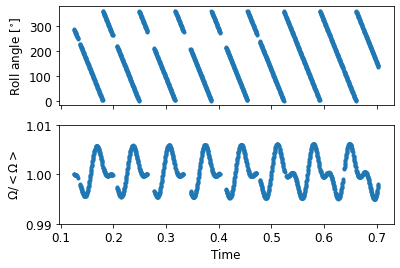

In [49]:
fig,ax = subplots(nrows=2,sharex=True)
t = M.datasets[0].lc['time']
t0 = floor(t[0])
roll_angle = M.datasets[0].lc['roll_angle']
ax[0].plot(t-t0,roll_angle,'.')
ax[0].set_ylabel('Roll angle [$^{\circ}$]')
drdt = gradient(roll_angle)
Omega = np.nanmedian(drdt)
ax[1].plot(t-t0,drdt/Omega,'.')
ax[1].set_ylim(0.99,1.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('$\Omega/<\Omega>$');

#### Removing roll-angle trend before fitting 
There are three options for dealing with the non-linear change of roll angle with time ...
1. Ignore it - this will be a good option if the trends are not large.
2. Increase `nroll`.
3. Remove the best-fit roll-angle trend determined using Dataset before fitting with MultiVisit.

To enable option 3 use `unwrap=True` - here is an example for KELT-11b.

In [50]:
result = M.fit_transit(log_omega0=ufloat(5.58,0.32), 
                       log_S0=ufloat(-23.29,0.64),
                       log_sigma_w=ufloat(-9.51, 0.23),
                       f_c=ufloat(-0.023, 0.281), 
                       f_s=ufloat(0.175, 0.159),
                       unroll=True, nroll=1, unwrap=True,
                       extra_priors={'h_1':star.h_1,
                                     'h_2':star.h_2,
                                     'logrho':star.logrho},
                       burn=512, steps=256, nwalkers=256) 
print(M.fit_report(min_correl=0.8))

Running burn-in ..


100%|██████████| 512/512 [04:58<00:00,  1.71it/s]

Running sampler ..



100%|██████████| 256/256 [02:28<00:00,  1.72it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 233523
    # data points      = 1493
    # variables        = 13
    chi-square         = 1689.06296
    reduced chi-square = 1.14125875
    Akaike info crit   = -18431.1106
    Bayesian info crit = -10574.4672
    RMS residual       = 170.5 ppm
[[Variables]]
    D:               0.00208623 +/- 9.2562e-05 (4.44%) (init = 0.002092767)
    W:               0.06249549 +/- 0.00153817 (2.46%) (init = 0.06333671)
    b:               0.30789264 +/- 0.17861109 (58.01%) (init = 0.3195883)
    P:               4.736525 (fixed)
    T_0:             1918.50170 +/- 9.2065e-04 (0.00%) (init = 1918.502)
    f_c:            -0.01900517 +/- 0.18978331 (998.59%) (init = -0.023)
    f_s:             0.09344543 +/- 0.11459030 (122.63%) (init = 0.175)
    h_1:             0.70535979 +/- 0.01069453 (1.52%) (init = 0.7078488)
    h_2:             0.46419265 +/- 0.04915334 (10.59%) (init = 0.4516209)
    k:               0.04567525 ==

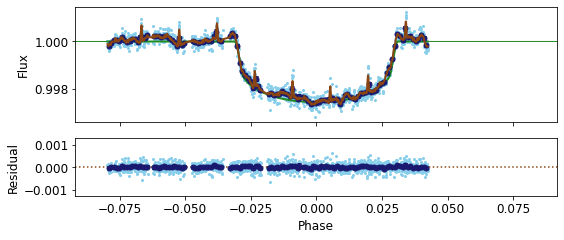

In [51]:
M.plot_fit();

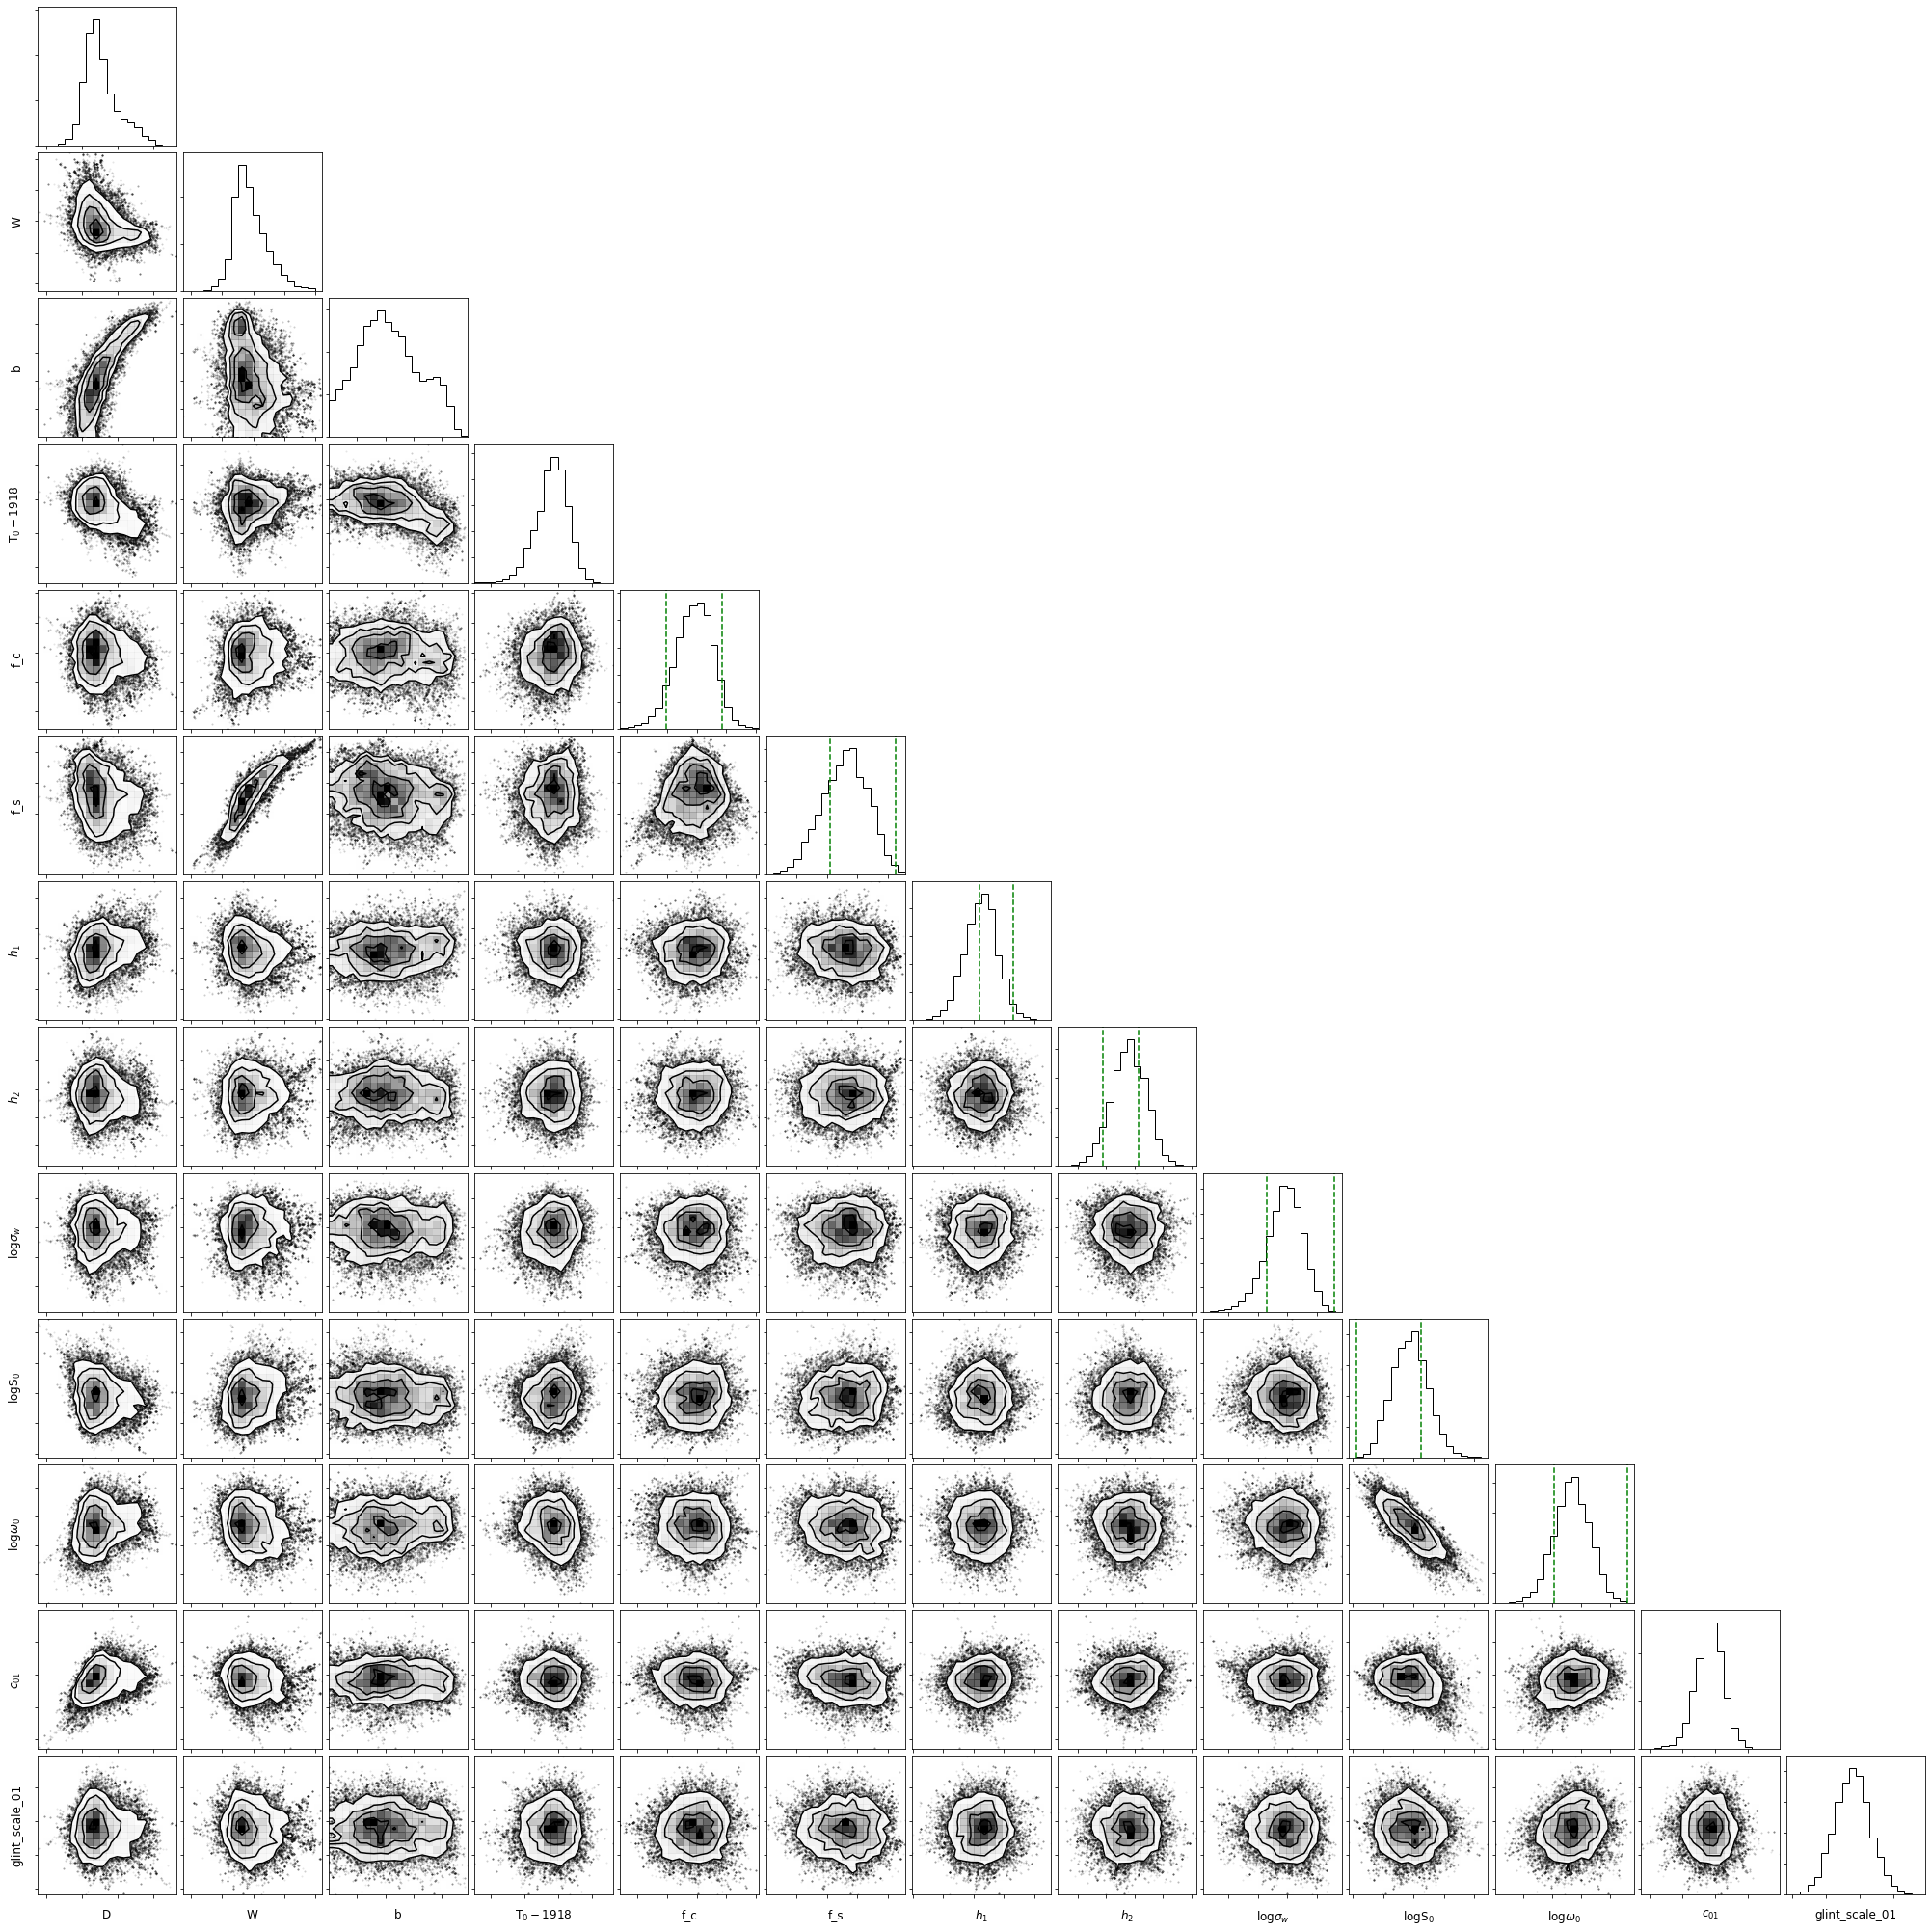

In [52]:
M.corner_plot(plotkeys='all');